# Simulate High Flux for 'Radiometric_Error_Analysis.ipynb'

Simulate the return from a hard target surface (like the ground or cloud)

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [2]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

fL = 2e3  # [Hz] laser rep rate for ABLE
tD = 20e-9  # [Hz] deadtime

In [446]:
amp = 3e6  # [Hz] amplitude of step (cloud or surface)
mu = 15   # [m] where the surface is
r_ABLE_bin = 50  # [m] the extend of the range bin
bgd = 0  # [Hz] background
t_res = 250e-12  # [s] very fine (almost time tag) resolution

num_bins = int(r_ABLE_bin/c*2//t_res)  # number of "time tage" bins within major bin

r_sim_bins = np.linspace(0, r_ABLE_bin, num_bins)  # [m]
t_sim_bins = r_sim_bins/c*2  # [s]
loc_center = np.round(mu/r_ABLE_bin * num_bins).astype(int)

flux = np.zeros(num_bins)  # [Hz]
flux[loc_center:] = 1  # [Hz] generate step function for flux
photon_rate_arr = flux * amp # [Hz]

### Simulate online and offline retrieval

In [459]:
Nshot = 200000
print('{} shots'.format(Nshot))
print('{:.3f} sec of simulated data'.format(Nshot/fL))

200000 shots
100.000 sec of simulated data


In [460]:
tau_aim = 1  # Aiming for optical depth value of 1 
phi_off = amp  # [Hz] offline flux
phi_on = phi_off / np.e**(2*tau_aim)
print('Ideal Optical Depth: {}'.format(tau_aim))
print('Offline Flux: {:.3f} MHz'.format(phi_off/1e6))
print('Online Flux: {:.3f} MHz'.format(phi_on/1e6))

Ideal Optical Depth: 1
Offline Flux: 3.000 MHz
Online Flux: 0.406 MHz


In [461]:
##### GENERATE SIMULATED DATA #####

# simulation resolution settings
if type(Nshot) != int:
    Nshot = int(Nshot)  # number of laser shots

wrap_deadtime = False

# generate photon counts

# lists of photon arrivals per laser shot
sync_idx = np.arange(Nshot)  # sync value
det_sync_idx = []
phot_sync_idx = []
det_events = []
phot_events = []

phi = [phi_off, phi_on]

for i in range(2):
    start = time.time()
    det_sync_idx_line = []
    phot_sync_idx_line = []
    det_events_line = []
    phot_events_line = []
    
    photon_rate_arr = phi[i] * flux  # [Hz]
    
    t_det_last = -100.0  # last photon detection event
    for n in range(Nshot):    
        # simulate a laser shot
        ptime, ctime = sim.photon_count_generator(np.append(t_sim_bins, t_sim_bins[-1]+t_res), photon_rate_arr, tau_d_flt=tD, last_photon_flt=t_det_last)
        if wrap_deadtime:
            if len(ctime) > 0:
                t_det_last = ctime[-1]
            t_det_last -= t_sim_bins[-1]

        ctime /= t_res  # convert from s to clock counts since sync event
        ptime /= t_res  # convert from s to clock counts since sync event

        for i in range(len(ctime)):
            det_events_line.append(ctime[i])  # detection time tags
            det_sync_idx_line.append(n)
        for i in range(len(ptime)):
            phot_events_line.append(ptime[i])  # photon time tags
            phot_sync_idx_line.append(n)

    print('Time elapsed: {} s'.format(time.time()-start))
    
    det_events.append(det_events_line)
    det_sync_idx.append(det_sync_idx_line)
    phot_events.append(phot_events_line)
    phot_sync_idx.append(phot_sync_idx_line)   

Time elapsed: 52.28710627555847 s
Time elapsed: 28.690275192260742 s


In [465]:
det_events_off = np.array(det_events[0])
det_sync_idx_off = np.array(det_sync_idx[0])
phot_events_off = np.array(phot_events[0])
phot_sync_idx_off = np.array(phot_sync_idx[0])
det_events_on = np.array(det_events[1])
det_sync_idx_on = np.array(det_sync_idx[1])
phot_events_on = np.array(phot_events[1])
phot_sync_idx_on = np.array(phot_sync_idx[1])

In [466]:
avg_range = np.logspace(1, 3, 100)
err = np.zeros(len(avg_range))
res = np.zeros(len(avg_range))  # [s]
for i in range(len(avg_range)):
    plot_bins = t_sim_bins[::np.floor(avg_range[i]).astype(int)]
    
    n_det_off, _ = np.histogram(det_events_off*t_res, bins=plot_bins)
    dt = np.diff(plot_bins)[0]
    det_flux_off = n_det_off/dt/Nshot

    n_phot_off, _ = np.histogram(phot_events_off*t_res, bins=plot_bins)
    phot_flux_off = n_phot_off/dt/Nshot

    n_det_on, _ = np.histogram(det_events_on*t_res, bins=plot_bins)
    det_flux_on = n_det_on/dt/Nshot

    n_phot_on, _ = np.histogram(phot_events_on*t_res, bins=plot_bins)
    phot_flux_on = n_phot_on/dt/Nshot
    
    muller_flux_off = det_flux_off / (1-tD*det_flux_off)  # [Hz]
    muller_flux_on = det_flux_on / (1-tD*det_flux_on)  # [Hz]
    
    error_off = np.abs(muller_flux_off - phot_flux_off)  # [Hz]
    error_on = np.abs(muller_flux_on - phot_flux_on)  # [Hz]
    edge_idx = np.nonzero(error_off)[0][0]
    
    tau = 1/2*np.log((muller_flux_off[edge_idx])/(muller_flux_on[edge_idx]))
    
    error = np.abs(tau-tau_aim)/tau_aim

#     print('Output Optical Depth: {:.3f}'.format(tau))
#     print('Error: {:.2f}%'.format(error*100))
    
    print('Range res: {:.2f} m\n'.format(dt*c/2))
    
    err[i] = error
    res[i] = dt

Range res: 0.38 m

Range res: 0.38 m

Range res: 0.38 m

Range res: 0.41 m

Range res: 0.45 m

Range res: 0.45 m

Range res: 0.49 m

Range res: 0.49 m

Range res: 0.53 m

Range res: 0.56 m

Range res: 0.56 m

Range res: 0.60 m

Range res: 0.64 m

Range res: 0.68 m

Range res: 0.71 m

Range res: 0.75 m

Range res: 0.79 m

Range res: 0.83 m

Range res: 0.86 m

Range res: 0.90 m

Range res: 0.94 m

Range res: 0.98 m

Range res: 1.01 m

Range res: 1.09 m

Range res: 1.13 m

Range res: 1.16 m

Range res: 1.24 m

Range res: 1.31 m

Range res: 1.35 m

Range res: 1.43 m

Range res: 1.50 m

Range res: 1.58 m

Range res: 1.65 m

Range res: 1.73 m

Range res: 1.80 m

Range res: 1.88 m

Range res: 1.99 m

Range res: 2.06 m

Range res: 2.18 m

Range res: 2.29 m

Range res: 2.40 m

Range res: 2.51 m

Range res: 2.63 m

Range res: 2.74 m

Range res: 2.89 m

Range res: 3.04 m

Range res: 3.15 m

Range res: 3.34 m

Range res: 3.49 m

Range res: 3.64 m

Range res: 3.83 m

Range res: 4.01 m

Range res: 4

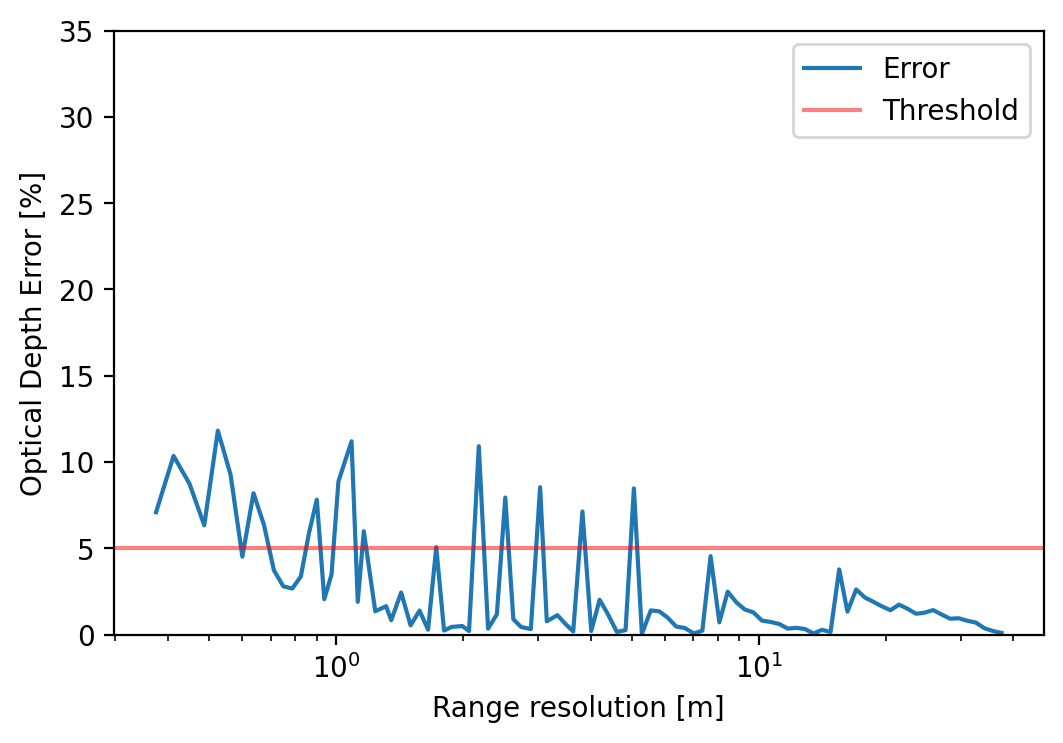

In [467]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(res*c/2, err*100, label='Error')
ax.axhline(5, color='red', alpha=0.5, label='Threshold')
ax.set_xlabel('Range resolution [m]')
ax.set_ylabel('Optical Depth Error [%]')
ax.set_xscale('log')
ax.set_ylim([0, 35])
plt.legend()
plt.show()

In [371]:
avg_range = 500
plot_bins = t_sim_bins[::avg_range]

n_det_off, _ = np.histogram(det_events_off*t_res, bins=plot_bins)
dt = np.diff(plot_bins)[0]
det_flux_off = n_det_off/dt/Nshot

n_phot_off, _ = np.histogram(phot_events_off*t_res, bins=plot_bins)
phot_flux_off = n_phot_off/dt/Nshot

n_det_on, _ = np.histogram(det_events_on*t_res, bins=plot_bins)
det_flux_on = n_det_on/dt/Nshot

n_phot_on, _ = np.histogram(phot_events_on*t_res, bins=plot_bins)
phot_flux_on = n_phot_on/dt/Nshot

print('Plotting range resolution: {:.2f} m'.format(dt*c/2))

Plotting range resolution: 18.75 m


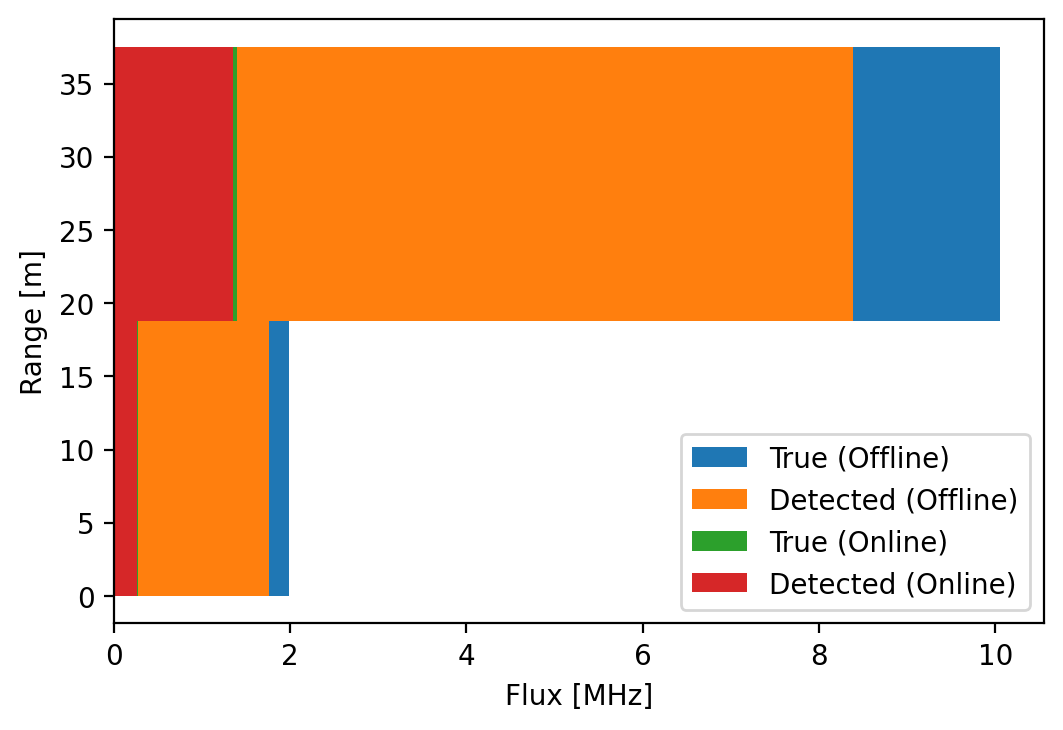

In [372]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_off/1e6, height=dt*c/2, label='True (Offline)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_off/1e6, height=dt*c/2, label='Detected (Offline)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_on/1e6, height=dt*c/2, label='True (Online)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_on/1e6, height=dt*c/2, label='Detected (Online)')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
plt.legend()
plt.show()

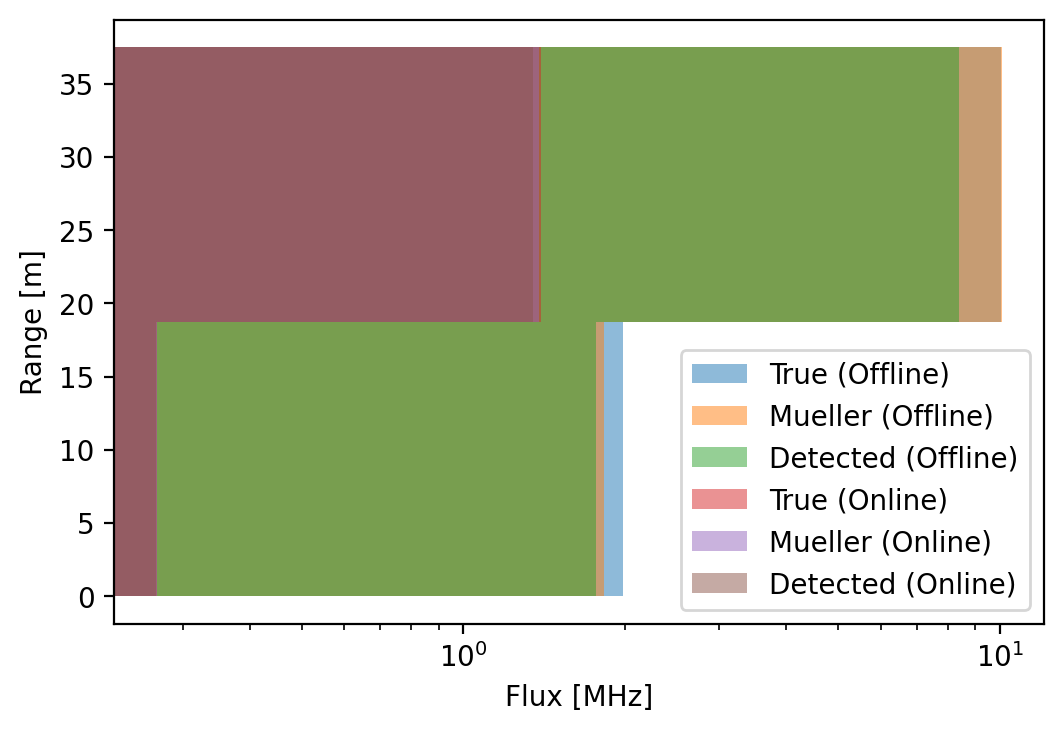

In [373]:
# calculate mueller correction

muller_flux_off = det_flux_off / (1-tD*det_flux_off)  # [Hz]
muller_flux_on = det_flux_on / (1-tD*det_flux_on)  # [Hz]
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_off/1e6, height=dt*c/2, label='True (Offline)', alpha=0.5)
ax.barh((plot_bins[:-1]+dt/2)*c/2, muller_flux_off/1e6, height=dt*c/2, label='Mueller (Offline)', alpha=0.5)
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_off/1e6, height=dt*c/2, label='Detected (Offline)', alpha=0.5)
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_on/1e6, height=dt*c/2, label='True (Online)', alpha=0.5)
ax.barh((plot_bins[:-1]+dt/2)*c/2, muller_flux_on/1e6, height=dt*c/2, label='Mueller (Online)', alpha=0.5)
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_on/1e6, height=dt*c/2, label='Detected (Online)', alpha=0.5)
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_xscale('log')
plt.legend()
plt.show()

In [374]:
error_off = np.abs(muller_flux_off - phot_flux_off)  # [Hz]
error_on = np.abs(muller_flux_on - phot_flux_on)  # [Hz]
edge_idx = np.nonzero(error_off)[0][0]

print("Mueller Error (Offline): {}".format(muller_flux_off - phot_flux_off))
print("Mueller Error (Online): {}".format(muller_flux_on - phot_flux_on))

Mueller Error (Offline): [-152341.41020393   35135.86853399]
Mueller Error (Online): [ -156.99824989 -7322.90697421]


In [375]:
tau_edge = 1/2*np.log((muller_flux_off[edge_idx])/(muller_flux_on[edge_idx]))
tau = 1/2*np.log((muller_flux_off)/(muller_flux_on))
# print(muller_flux_off)

print('Edge bin')
print('Output Optical Depth: {:.3f}'.format(tau_edge))
print('Error: {:.2f}%'.format(np.abs(tau_edge-tau_aim)/tau_aim*100))

Edge bin
Output Optical Depth: 0.958
Error: 4.15%


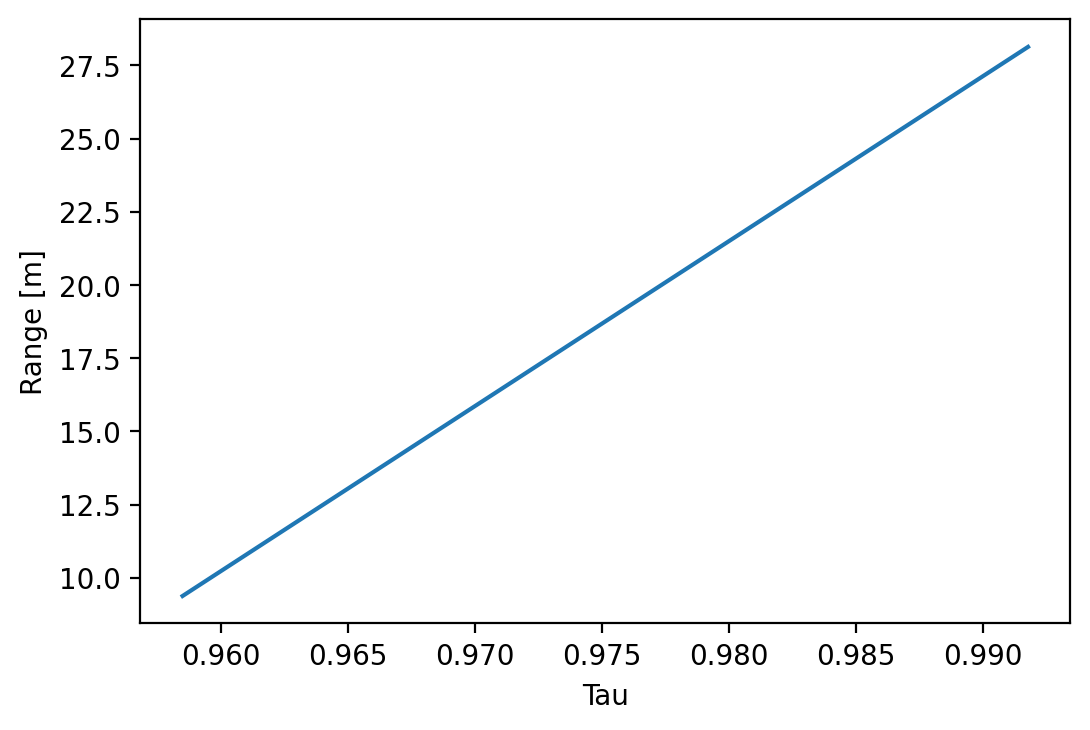

In [376]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(tau, (plot_bins[:-1]+dt/2)*c/2)
ax.set_ylabel('Range [m]')
ax.set_xlabel('Tau')
plt.show()